# 스마트 정수장 알고리즘 시계열기반 추출 학습: 약품 공정

### 1. 필요한 Python 라이브러리 Import 하기

In [1]:
import numpy as np
import pandas as pd
import datetime
import scipy
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pickle
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

if platform.system() == "Darwin":  #
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="NanumGothic")

fe = fm.FontEntry(
    fname=r"/usr/share/fonts/truetype/nanum/NanumGothic.ttf",  # ttf 파일이 저장되어 있는 경로
    name="NanumGothic",
)  # 원하는 폰트 설정
fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가

plt.rcParams.update({"font.size": 18, "font.family": "NanumGothic"})  # 폰트 설정

plt.rcParams["axes.unicode_minus"] = False

### 2. 전처리된 데이터 불러오기

In [2]:
load_df = pd.read_csv("SN_total.csv")
load_df = load_df.set_index("시간")
load_df.index = pd.DatetimeIndex(load_df.index)
raw_df = load_df.copy()
raw_df.head(5)

,원수 탁도,원수 pH,원수 알칼리도,원수 전기전도도,원수 수온,3단계 원수 유입 유량,3단계 1계열 응집제 주입률,3단계 침전지 탁도,3단계 침전지 체류시간,3단계 여과지 탁도
시간,,,,,,,,,,
2020-01-01 12:59:00,2.477549,8.257175,54.961955,222.781944,4.616253,11183.916667,13.54400,0.282890,256.817051,0.045849
2020-01-01 13:29:00,2.439258,8.271153,55.155387,222.880161,4.629616,11205.916667,13.55400,0.291072,260.570714,0.046010
2020-01-01 13:59:00,2.421914,8.282444,55.320712,224.263970,4.629758,11503.791667,13.59700,0.297960,270.520977,0.045904
2020-01-01 14:29:00,2.398210,8.286200,55.872316,224.579963,4.626820,11781.125000,13.66800,0.312246,260.697341,0.050281
2020-01-01 14:59:00,2.408023,8.288734,56.368194,224.477999,4.620842,12237.833333,13.68725,0.317849,238.363311,0.047650


### 3. 변수 추가 (Log)

In [3]:
df = raw_df.copy()

In [4]:
df["로그 원수 탁도"] = np.log10(df["원수 탁도"])
df["로그 응집제 주입률"] = np.log10(df["3단계 1계열 응집제 주입률"])
df

,원수 탁도,원수 pH,원수 알칼리도,원수 전기전도도,원수 수온,3단계 원수 유입 유량,3단계 1계열 응집제 주입률,3단계 침전지 탁도,3단계 침전지 체류시간,3단계 여과지 탁도,로그 원수 탁도,로그 응집제 주입률
시간,,,,,,,,,,,,
2020-01-01 12:59:00,2.477549,8.257175,54.961955,222.781944,4.616253,11183.916667,13.54400,0.282890,256.817051,0.045849,0.394022,1.131747
2020-01-01 13:29:00,2.439258,8.271153,55.155387,222.880161,4.629616,11205.916667,13.55400,0.291072,260.570714,0.046010,0.387258,1.132067
2020-01-01 13:59:00,2.421914,8.282444,55.320712,224.263970,4.629758,11503.791667,13.59700,0.297960,270.520977,0.045904,0.384159,1.133443
2020-01-01 14:29:00,2.398210,8.286200,55.872316,224.579963,4.626820,11781.125000,13.66800,0.312246,260.697341,0.050281,0.379887,1.135705
2020-01-01 14:59:00,2.408023,8.288734,56.368194,224.477999,4.620842,12237.833333,13.68725,0.317849,238.363311,0.047650,0.381661,1.136316
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 20:59:00,1.787780,7.822680,41.094511,184.020745,3.158893,9660.916667,12.99750,0.362827,301.454702,0.048515,0.252314,1.113860
2022-12-31 21:29:00,1.784237,7.820758,40.703410,183.270915,3.163575,9705.458333,12.99750,0.362005,293.208228,0.048349,0.251453,1.113860
2022-12-31 21:59:00,1.765750,7.818412,40.405968,182.062842,3.166926,9854.541667,12.99750,0.364164,289.729565,0.048677,0.246929,1.113860


In [5]:
X = df[
    [
        "로그 원수 탁도",
        "원수 pH",
        "원수 알칼리도",
        "원수 전기전도도",
        "원수 수온",
        "3단계 원수 유입 유량",
        "3단계 침전지 체류시간",
    ]
]
y = df["로그 응집제 주입률"]
Xt, Xts, yt, yts = train_test_split(X, y, test_size=0.2, shuffle=False)

### 4. Lasso 모델 개발

In [24]:
std_scaler = StandardScaler()
selector = SelectKBest(score_func=r_regression, k=5)
regressor = Lasso()

model_pipe = Pipeline(
    [
        ("scaler", std_scaler),
        ("feature_selector", selector),
        ("regressor", regressor),
    ]
)
params = {
    "feature_selector__k": np.arange(2, Xt.shape[1] + 1, 1),
    "regressor__alpha": 10 ** np.arange(-4, 5, 1).astype(float),
}

rscv = RandomizedSearchCV(model_pipe, params, n_iter=30)
rscv.fit(Xt, yt)
model = rscv.best_estimator_
model

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_selector',
                 SelectKBest(k=7,
                             score_func=<function r_regression at 0x7fb6d89c5800>)),
                ('regressor', Lasso(alpha=0.001))])

### 5. 모델 성능평가

In [10]:
yt_pred = model.predict(Xt)
yts_pred = model.predict(Xts)

mse_train = mean_squared_error(10**yt, 10**yt_pred)
mse_test = mean_squared_error(10**yts, 10**yts_pred)
print(f"학습 데이터 MSE: {mse_train}")
print(f"테스트 데이터 MSE: {mse_test}")

r2_train = r2_score(10**yt, 10**yt_pred)
r2_test = r2_score(10**yts, 10**yts_pred)
print(f"학습 데이터 R2: {r2_train}")
print(f"테스트 데이터 R2: {r2_test}")

학습 데이터 MSE: 7.379652670909498
테스트 데이터 MSE: 9.384715338291054
학습 데이터 R2: 0.7249732141149359
테스트 데이터 R2: 0.7909967455321334


Text(0.5, 1.0, '테스트 데이터  MSE: 9.3847, $R^2$: 0.79')

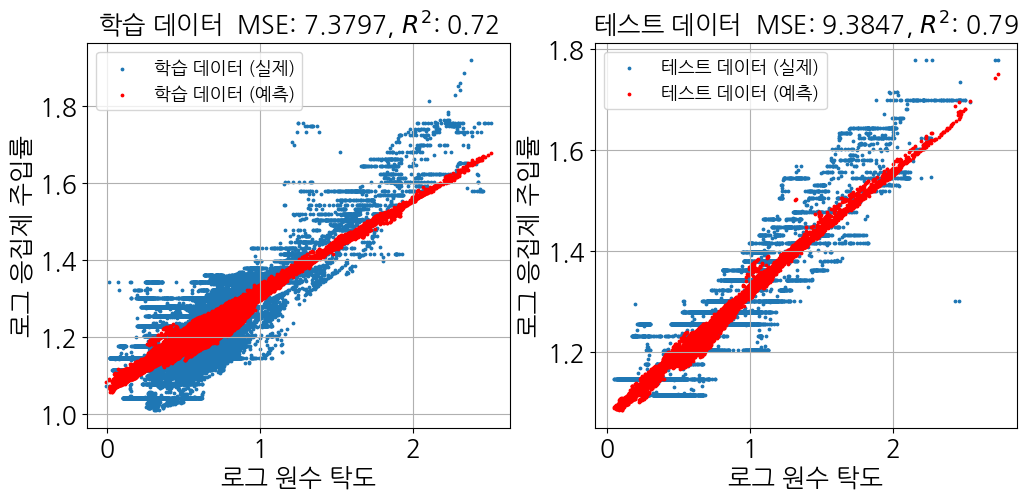

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ax = axes[0]
ax.scatter(Xt["로그 원수 탁도"], yt, s=3, label="학습 데이터 (실제)")
ax.scatter(Xt["로그 원수 탁도"], yt_pred, s=3, label="학습 데이터 (예측)", c="r")
ax.grid()
ax.legend(fontsize=13)
ax.set_xlabel("로그 원수 탁도")
ax.set_ylabel("로그 응집제 주입률")
ax.set_title(
    rf"학습 데이터  MSE: {round(mse_train, 4)}, $R^2$: {round(r2_train, 2)}",
    fontsize=18,
)

ax = axes[1]
ax.scatter(Xts["로그 원수 탁도"], yts, s=3, label="테스트 데이터 (실제)")
ax.scatter(Xts["로그 원수 탁도"], yts_pred, s=3, label="테스트 데이터 (예측)", c="r")
ax.grid()
ax.legend(fontsize=13)
ax.set_xlabel("로그 원수 탁도")
ax.set_ylabel("로그 응집제 주입률")
ax.set_title(
    rf"테스트 데이터  MSE: {round(mse_test, 4)}, $R^2$: {round(r2_test, 2)}",
    fontsize=18,
)

### 6. Lasso 저장 및 불러와서 사용하기

In [18]:
with open("rasso.pickle", "wb") as f:
    pickle.dump(rscv, f)

In [19]:
with open("rasso.pickle", "rb") as f:
    rasso_model = pickle.load(f)

In [ ]:
from sklearn.metrics import mean_squared_error

# 테스트 세트의 레이블을 예측합니다.
y_pred = rasso_model.predict(Xts)

# rmse를 계산합니다.
mse_test = mean_squared_error(10**yts, 10**y_pred)

# rmse를 출력합니다.
print("테스트 세트 점수: {:.3f}".format(mse_test))

테스트 세트 점수: 9.385
